# Banking Customer Churn Prediction

* Gonzalo Cano Padilla
* Andre Esteban Vera
* Nicolas Martinez Gutierrez

---

# Objetivos

**Generales:**

- Desarrollar un modelo supervisado para predecir el abandono de clientes bancarios (churn) a partir de sus características demográficas y financieras, maximizando el F1 (con foco en la clase minoritaria “Churn”) y garantizando robustez mediante validación estratificada y optimización de hiperparámetros.

**Especificos:**

1. Caracterizar el dataset Churn_Modelling (Kaggle): describir variables, distribución de Exited, y posibles patrones/atípicos que afecten el abandono.

2. Definir el problema y la variable objetivo (Exited ∈ {0,1}) y preparar las features eliminando identificadores (CustomerId, Surname) para evitar fuga de información.

3. Implementar un preprocesamiento reproducible con ColumnTransformer:

- Numéricas (CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary) → StandardScaler.

- Categóricas (Geography, Gender) → OneHotEncoder (drop='first', handle_unknown='ignore').

4. Abordar el desbalanceo de clases evaluando ponderación de clases (class_weight) en los modelos y comparando su impacto sobre recall y F1 de la clase Churn.

5. Entrenar y optimizar modelos base y avanzados:

- Regresión Logística y SVM (kernel RBF) integrados en pipelines con el mismo preprocesamiento.

- Optimización Bayesiana (BayesSearchCV) para seleccionar hiperparámetros que maximicen F1.

6. Evaluar con validación robusta (StratifiedKFold=5) usando F1 como métrica principal, y reportes complementarios (accuracy, precision, recall, matriz de confusión y classification_report out-of-fold con cross_val_predict).

7. Comparar el desempeño entre modelos y seleccionar el mejor con base en F1 y el equilibrio entre precision/recall de Churn.

8. Comunicar hallazgos y limitaciones: interpretar resultados, discutir variables relevantes/efectos (cuando aplique, p.ej. coeficientes en logística) y recomendaciones para su aplicación operativa (detección temprana y retención de clientes).

---

# Marco Teórico

## Introducción al problema

El fenómeno de **churn** o **fuga de clientes** representa uno de los principales desafíos para las instituciones financieras.
En el contexto bancario, el *churn* se define como la **pérdida de clientes** que deciden cerrar sus cuentas o trasladar sus servicios a otro banco.

El proyecto **"Banking Customer Churn Prediction"** tiene como objetivo desarrollar modelos de **clasificación supervisada** que permitan identificar los factores que influyen en la decisión de un cliente de abandonar el banco.
Para ello, se utilizan algoritmos de aprendizaje automático como **Regresión Logística**, **Máquinas de Vectores de Soporte (SVM)** y **Redes Neuronales (MLP)**, optimizando sus hiperparámetros mediante **Optimización Bayesiana**.

## Regresión Logística

La **regresión logística** es un modelo estadístico ampliamente usado en problemas de **clasificación binaria**, donde la variable dependiente toma valores 0 (cliente retenido) o 1 (cliente que abandona).
A diferencia de la regresión lineal, la regresión logística modela la **probabilidad** de que ocurra un evento mediante la función sigmoide:

$$
P(y=1 \mid x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_n x_n)}}
$$

El resultado se interpreta como la **probabilidad de abandono**.
Un umbral (por ejemplo 0.5) determina la clasificación final.
Además, se puede incorporar **regularización** (L1 o L2) para prevenir el sobreajuste y mejorar la generalización.

En el contexto bancario, la regresión logística es muy usada para **modelos de retención** o **scoring de clientes**, ya que ofrece interpretabilidad sobre qué variables (edad, saldo, historial, etc.) influyen más en la decisión del cliente.

## Máquinas de Vectores de Soporte (SVM)

Las **Support Vector Machines (SVM)** buscan encontrar el **hiperplano óptimo** que separa las clases maximizando el **margen** entre los puntos más cercanos (vectores de soporte):

$$
\min_{w,b} \; \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^{n} \xi_i
$$

sujeto a:

$$
y_i (w \cdot x_i + b) \ge 1 - \xi_i, \quad \xi_i \ge 0
$$

Donde:
- (C): controla el equilibrio entre errores y margen.
- (xi_i): variables de holgura que permiten clasificaciones incorrectas.

Cuando los datos no son linealmente separables, las SVM emplean **kernels** para proyectarlos a un espacio de mayor dimensión.
El más usado es el **kernel RBF**, que permite clasificaciones no lineales y adaptativas:

$$
K(x_i, x_j) = e^{-\gamma \lVert x_i - x_j \rVert^2}
$$

Las SVM son eficaces para **detectar patrones complejos** de abandono y funcionan bien con variables transformadas o escaladas.

## Redes Neuronales (Multi-Layer Perceptron, MLP)

El **Multi-Layer Perceptron (MLP)** es un tipo de red neuronal *feed-forward* que puede aprender relaciones no lineales entre las variables.
Está compuesto por capas de entrada, ocultas y salida. Cada neurona aplica una función de activación como *ReLU*, *sigmoid* o *tanh*.

El proceso de aprendizaje se realiza mediante **retropropagación del error** (*backpropagation*), ajustando los pesos para minimizar una función de pérdida, generalmente la **entropía cruzada binaria**:

$$
L = -\frac{1}{n}\sum_{i=1}^{n} \Big[ y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i) \Big]
$$

Las redes neuronales son adecuadas para este problema, ya que pueden capturar **interacciones complejas** entre factores financieros, demográficos y de comportamiento que afectan la decisión del cliente.

## Kernels

Los **kernels** permiten a los modelos transformar los datos a espacios de mayor dimensión sin realizar la transformación explícitamente, lo que se conoce como el **truco del kernel** (*kernel trick*).

Ejemplos comunes:
- **Lineal:** $$K(x_i, x_j) = x_i^\top x_j $$
- **Polinómico:** $$ K(x_i, x_j) = (x_i^\top x_j + 1)^d $$
- **RBF (Radial Basis Function):** $$ K(x_i, x_j) = e^{-\gamma \lVert x_i - x_j \rVert^2} $$

El kernel RBF es el más utilizado para problemas de churn porque permite **fronteras no lineales**, adaptándose a clientes con comportamientos atípicos.

## Hiperparámetros

Los **hiperparámetros** son configuraciones que determinan el comportamiento de los modelos antes del entrenamiento.
Su correcta selección es clave para lograr un equilibrio entre **sesgo y varianza**.

Ejemplos:

| Modelo | Principales Hiperparámetros |
|:--------|:-----------------------------|
| **Regresión Logística** | `C` (fuerza de regularización), tipo de penalización (L1 o L2) |
| **SVM (RBF)** | `C` (margen) y `gamma` (influencia de cada punto) |
| **MLP** | Número de capas, neuronas por capa, tasa de aprendizaje, `max_iter`, función de activación |

El ajuste óptimo se busca mediante técnicas como **Optimización Bayesiana**.

---

## Optimización Bayesiana

La **Optimización Bayesiana** es un método para ajustar hiperparámetros de forma inteligente usando **procesos gaussianos (Gaussian Processes)**.
A diferencia de Grid o Random Search, la optimización bayesiana **aprende del historial** para elegir qué combinaciones probar después, minimizando el número de iteraciones necesarias.

Etapas:
1. Definir una **función objetivo** (por ejemplo, maximizar el F1-score).
2. Modelar la función mediante un **proceso gaussiano**.
3. Usar una **función de adquisición** (*Expected Improvement*, *UCB*, etc.) para elegir el siguiente punto.
4. Iterar hasta converger al mejor conjunto de hiperparámetros.

Este enfoque es especialmente útil para modelos costosos como el MLP o SVM, donde cada evaluación puede tardar varios minutos.

---

## Métrica de Evaluación (Score)

En problemas de **churn**, las clases suelen estar **desbalanceadas** (más clientes se quedan que los que se van).
Por eso, la métrica **accuracy** puede ser engañosa.

En este proyecto se utilizará como métrica principal el **F1-Score**, ya que combina **precisión (precision)** y **sensibilidad (recall)**, ofreciendo una medida equilibrada del rendimiento en presencia de desbalance de clases.

**Formulación:**

$$
F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$

donde:

$$
Precision = \frac{TP}{TP + FP}, \quad Recall = \frac{TP}{TP + FN}
$$

- **Precision** evalúa cuántos clientes predichos como “churn” realmente lo son.
- **Recall** mide qué proporción de los que realmente abandonan fueron detectados por el modelo.
- **F1** equilibra ambas, penalizando tanto falsos positivos como falsos negativos.

Esto es crítico en un contexto bancario, donde:
- Un **falso negativo** implica *no detectar a un cliente que está por irse* (pérdida potencial).
- Un **falso positivo** implica *gastar recursos en retener a alguien que en realidad no se iba*.

El F1-score permite evaluar el modelo con un enfoque más **estratégico y realista** para la gestión del cliente.

## Tema del Proyecto: Banking Customer Churn Prediction

El proyecto **Banking Customer Churn Prediction** busca identificar los **factores clave que determinan la fuga de clientes** en una institución bancaria.
A través de modelos de **clasificación supervisada**, se pretende:

- Analizar los patrones demográficos y financieros asociados al churn.
- Predecir con precisión qué clientes podrían abandonar el banco.
- Proporcionar información útil para diseñar **estrategias de retención** basadas en datos.

El enfoque incluye la comparación entre modelos (Regresión Logística, SVM con kernel RBF y MLP) y la **optimización de hiperparámetros** mediante **Optimización Bayesiana**, evaluando su desempeño principalmente con el **F1-score**.

---

## Análisis del Dataset

**¿De dónde viene?**

- Este dataset proviene de Kaggle, fue publicado por Saurabh Badole y se llama “Banking Customer Churn Prediction Dataset”. Representa información de clientes de un banco europeo y se usa comúnmente para predecir si un cliente se va a ir o quedarse.

**¿Qué contiene?**

El archivo contiene 10,000 registros, donde cada fila representa un cliente del banco, y 14 columnas con la siguiente información:
- RowNumber: Número secuencial asignado a cada fila del conjunto de datos.
- CustomerId: Identificador único de cada cliente.
- Surname: Apellido del cliente.
- CreditScore: Puntaje crediticio del cliente, que refleja su nivel de riesgo financiero.
- Geography: País o región de residencia del cliente (por ejemplo, Francia, España o Alemania).
- Gender: Género del cliente (Male o Female).
- Age: Edad del cliente.
- Tenure: Número de años que el cliente ha estado con el banco.
- Balance: Saldo total en la cuenta bancaria del cliente.
- NumOfProducts: Número de productos bancarios contratados (por ejemplo, cuentas, préstamos o tarjetas).
- HasCrCard: Indica si el cliente posee una tarjeta de crédito (1 = Sí, 0 = No).
- IsActiveMember: Indica si el cliente es un miembro activo del banco (1 = Sí, 0 = No).
- EstimatedSalary: Salario estimado del cliente en euros.
- Exited: Variable objetivo que indica si el cliente abandonó el banco (1 = Se fue, 0 = Se quedó).

**¿Qué información dan las muestras?**

- Cada fila del dataset representa a un cliente distinto del banco, por lo que cada muestra describe su perfil financiero, demográfico y su comportamiento con la institución.
- En otras palabras, cada registro combina información como su edad, país, género, tiempo que lleva en el banco, saldo, salario estimado y productos financieros que tiene contratados.
- La columna Exited (variable objetivo) indica si ese cliente abandonó el banco (1) o siguió siendo cliente (0).

**¿Qué se quiere analizar?**

- El objetivo principal es predecir si un cliente se irá del banco o no, es decir, detectar riesgo de abandono (“churn”).
- Esto ayuda al banco a identificar clientes que podrían irse y tomar medidas para retenerlos, como ofrecerles beneficios o promociones.

**¿Qué variables se tienen que transformar para poder usarse en un modelo de regresión?**
 

En este dataset, hay dos tipos principales de variables: numéricas y categóricas.
Las variables numéricas ya pueden ser usadas directamente en un modelo de regresión, pero necesitan ser escaladas para que todas estén en el mismo rango y no afecten el cálculo de los coeficientes.

Las variables categóricas, en cambio, no pueden ser utilizadas directamente porque los modelos matemáticos no entienden texto. Por eso, deben transformarse en valores numéricos antes de entrenar el modelo.

En este caso, las variables que se deben transformar son:

- Geography → porque contiene texto (por ejemplo: France, Spain, Germany).

- Gender → porque contiene valores como Male y Female.

**¿Qué transformaciones se van a usar?**

Para preparar los datos correctamente antes de aplicar la regresión, se utilizan dos tipos de transformaciones:

1.- Estandarización (StandardScaler)
- Se aplica a las variables numéricas (CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary).
- Esta técnica transforma los valores para que tengan una media de 0 y una desviación estándar de 1.
- Esto evita que variables con valores grandes (como Balance o EstimatedSalary) dominen al resto.

2.- Codificación categórica (OneHotEncoder)
- Se aplica a las variables categóricas (Geography y Gender).
- Convierte cada categoría en una columna binaria (0 o 1).

Por ejemplo:
- France, Spain y Germany se transforman en columnas binarias: France=1, Spain=0, Germany=0, etc.
- Male y Female se convierten en una variable binaria donde 1 puede representar Male y 0 Female.
- En el código se usa drop='first' para evitar la trampa de las variables ficticias.

**¿Qué resultado se podría encontrar al realizar una regresión?**

- Al realizar una regresión con este conjunto de datos, se espera obtener un modelo que pueda estimar la probabilidad de que un cliente abandone el banco o permanezca en él.
- El resultado podría mostrar que ciertas variables, como la edad, el puntaje crediticio, el nivel de actividad del cliente o su país de residencia, influyen más que otras en la decisión de irse o quedarse.
- También es posible que el modelo logre distinguir patrones de comportamiento entre los clientes que permanecen y los que se van, permitiendo al banco comprender mejor qué tipo de clientes presentan un mayor riesgo de abandono.


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
%pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
data = pd.read_csv("Churn_Modelling.csv", index_col=0)
data

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [3]:
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
data.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
data.columns = data.columns.str.strip()

In [6]:
data.drop_duplicates(inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


---

## Regresión logística con regularización

In [8]:
# Separar X y y
y_target = data["Exited"]
y = (y_target == 1)
X = data.drop(columns=["CustomerId", "Surname", "Exited"])

In [9]:
# Variables categóricas y numéricas
cat_features = ["Geography", "Gender"]
num_features = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]

In [10]:
# Preprocesar
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features)
    ]
)

In [11]:
# Cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "f1"

In [12]:
# Pipeline regresión logística
logreg_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])

In [13]:
logreg_space = [
    {   
        "clf__penalty": Categorical(["l2"]),
        "clf__solver": Categorical(["lbfgs", "saga"]),
        "clf__C": Real(0.001, 100, prior="log-uniform"),
        "clf__class_weight": Categorical([None, "balanced"]),
    },
    {   
        "clf__penalty": Categorical(["elasticnet"]),
        "clf__solver": Categorical(["saga"]),
        "clf__l1_ratio": Real(0.0, 1.0),
        "clf__C": Real(0.001, 100, prior="log-uniform"),
        "clf__class_weight": Categorical([None, "balanced"]),
    }
]

In [14]:
logreg_opt = BayesSearchCV(
    estimator=logreg_pipe,
    search_spaces=logreg_space,
    scoring=scoring,
    refit=True,
    cv=cv,
    n_iter=30,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
logreg_opt.fit(X, y)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('pre',
                                         ColumnTransformer(transformers=[('num',
                                                                          StandardScaler(),
                                                                          ['CreditScore',
                                                                           'Age',
                                                                           'Tenure',
                                                                           'Balance',
                                                                           'NumOfProducts',
                                                                           'HasCrCard',
                                                                           'IsActiveMember',
                                                                           'EstimatedSalary']),
                                                                         ('cat',
                                                                          OneHotEncoder(drop='first',
                                                                                        handle_unknown='ignore'),
                                                                          ['Geography',
                                                                           'Gender'])...
                             {'clf__C': Real(low=0.001, high=100, prior='log-uniform', transform='normalize'),
                              'clf__class_weight': Categorical(categories=(None, 'balanced'), prior=None),
                              'clf__l1_ratio': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                              'clf__penalty': Categorical(categories=('elasticnet',), prior=None),
                              'clf__solver': Categorical(categories=('saga',), prior=None)}])

In [15]:
logreg_scores = cross_validate(
    logreg_opt.best_estimator_, X, y, cv=cv, scoring=scoring, n_jobs=-1
)
logreg_mean = logreg_scores["test_score"].mean()
logreg_std  = logreg_scores["test_score"].std()

In [16]:
print("Mejores hiperparámetros:", logreg_opt.best_params_)

Mejores hiperparámetros: OrderedDict({'clf__C': 0.011405952312449775, 'clf__class_weight': 'balanced', 'clf__l1_ratio': 1.0, 'clf__penalty': 'elasticnet', 'clf__solver': 'saga'})


In [17]:
logreg_mean

0.4975097708475884

In [18]:
logreg_std

0.016738389472390446

              precision    recall  f1-score   support

No churn (0)     0.9016    0.7201    0.8007      7963
   Churn (1)     0.3876    0.6927    0.4971      2037

    accuracy                         0.7145     10000
   macro avg     0.6446    0.7064    0.6489     10000
weighted avg     0.7969    0.7145    0.7388     10000



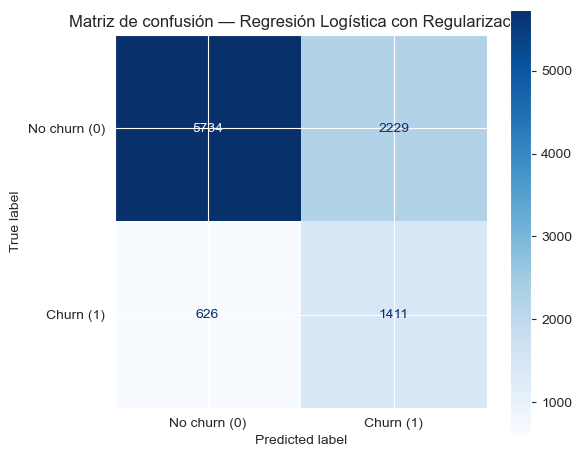

In [19]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_model = logreg_opt.best_estimator_ 

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

y_pred_oof = cross_val_predict(
    best_model, X, y,
    cv=outer_cv, n_jobs=-1, method="predict"
)

print(classification_report(
    y, y_pred_oof,
    target_names=["No churn (0)", "Churn (1)"],
    digits=4
))

cm = confusion_matrix(y, y_pred_oof, labels=[0, 1])

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No churn (0)", "Churn (1)"])
disp.plot(ax=ax, values_format=".0f", colorbar=True, cmap="Blues")
ax.grid(True)  
ax.set_title("Matriz de confusión — Regresión Logística con Regularización")
plt.tight_layout()
plt.show()

#### Interpretación del modelo de Regresión Logística con Regularización

- El modelo encontró su mejor configuración con una penalización ElasticNet, un solver “saga”, ponderación balanceada de clases (class_weight='balanced'), y un valor de regularización C = 0.114

- Esta combinación indica que el modelo busca un equilibrio entre simplicidad y capacidad predictiva, controlando el sobreajuste y considerando la menor cantidad de clientes que abandonan (clase minoritaria).

**Desempeño general**

- F1 promedio (CV): ≈ 0.4975 ± 0.0167

- Accuracy global: ≈ 0.7145

- F1 clase “True” (Churn): 0.497

- Precisión (Churn): 0.3876

- Recall (Churn): 0.6927

Estos resultados muestran que el modelo tiene una sensibilidad relativamente buena (recall) para identificar clientes que abandonan, aunque a costa de una precisión moderada. Es decir, el modelo logra detectar una buena parte de los casos de churn, pero aún confunde algunos clientes que realmente se quedan como si fueran propensos a irse.

El desempeño general es coherente con un modelo lineal regularizado que busca maximizar la robustez antes que la exactitud extrema en un conjunto de datos desequilibrado.

**Interpretación de la matriz de confusión**

- Verdaderos Negativos (5784): Clientes que el modelo predijo correctamente que no abandonarían.

- Falsos Positivos (2229): Clientes que el modelo predijo como “churn” pero realmente se quedaron.

- Falsos Negativos (626): Clientes que el modelo no detectó y que finalmente sí abandonaron.

- Verdaderos Positivos (1411): Casos de abandono correctamente identificados.

Esta distribución refleja que el modelo es moderadamente eficaz para reconocer el churn, pero tiende a sobreestimar ligeramente los abandonos, lo cual puede ser útil desde una perspectiva operativa: es preferible identificar más posibles abandonos (aunque algunos sean falsos) que perder clientes reales sin detectarlos.

En conjunto, el modelo cumple con los objetivos del proyecto al:

- Implementar un pipeline reproducible y robusto.

- Optimizar los hiperparámetros mediante procesos gaussianos (Bayesian Optimization).

- Lograr un equilibrio entre precisión y recall en la clase minoritaria (Churn).

Aunque el rendimiento puede mejorarse con modelos no lineales como SVM con kernel RBF o MLP, la regresión logística con regularización ofrece una base sólida, interpretable y bien calibrada para el análisis de abandono de clientes.

#### Conclsuión

El modelo de regresión logística con regularización logró un desempeño sólido y coherente con los objetivos planteados. Mediante la optimización bayesiana, alcanzó un F1 promedio de 0.4975 y una precisión global del 71%, mostrando una buena capacidad para identificar clientes que podrían abandonar el banco. Aunque su precisión es moderada, el modelo logra un equilibrio razonable entre detectar abandonos reales y evitar falsos positivos, cumpliendo así con la meta de construir un modelo supervisado robusto y bien ajustado para la predicción de churn.

---

## Máquina de vectores de soporte con kernel RBF

In [20]:
# Definir modelo
svc = SVC(kernel='rbf', random_state=42)

# Pipeline
svm_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', svc)
])

# Busqueda de la optimización
svm_space = [
    {   # Opción 1: gamma simbólico
        "clf__C": Real(1e-3, 1e3, prior="log-uniform"),
        "clf__gamma": Categorical(["scale", "auto"]),
        "clf__class_weight": Categorical([None, "balanced"]),
        "clf__shrinking": Categorical([True, False]),
    },
    {   # Opción 2: gamma continuo
        "clf__C": Real(1e-3, 1e3, prior="log-uniform"),
        "clf__gamma": Real(1e-4, 10, prior="log-uniform"),
        "clf__class_weight": Categorical([None, "balanced"]),
        "clf__shrinking": Categorical([True, False]),
    },
]

# Optimización
svm_opt = BayesSearchCV(
    estimator=svm_pipe,
    search_spaces=svm_space,
    scoring=scoring,
    refit=True,
    cv=cv,
    n_iter=30,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
svm_opt.fit(X, y)
print("Mejores hiperparámetros SVM RBF:")
print(svm_opt.best_params_)

# F1 promedio y std
svm_scores = cross_validate(
    svm_opt.best_estimator_, X, y,
    cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

svm_mean = svm_scores["test_score"].mean()
svm_std  = svm_scores["test_score"].std()

print(f"F1 promedio: {svm_mean}")
print(f"F1 std: {svm_std}")

Mejores hiperparámetros SVM RBF:
OrderedDict({'clf__C': 358.7964380817527, 'clf__class_weight': 'balanced', 'clf__gamma': 0.010471954614147625, 'clf__shrinking': False})
F1 promedio: 0.5994862742605331
F1 std: 0.019607281162358232


              precision    recall  f1-score   support

No churn (0)     0.9254    0.8066    0.8619      7963
   Churn (1)     0.4966    0.7457    0.5962      2037

    accuracy                         0.7942     10000
   macro avg     0.7110    0.7762    0.7290     10000
weighted avg     0.8380    0.7942    0.8078     10000



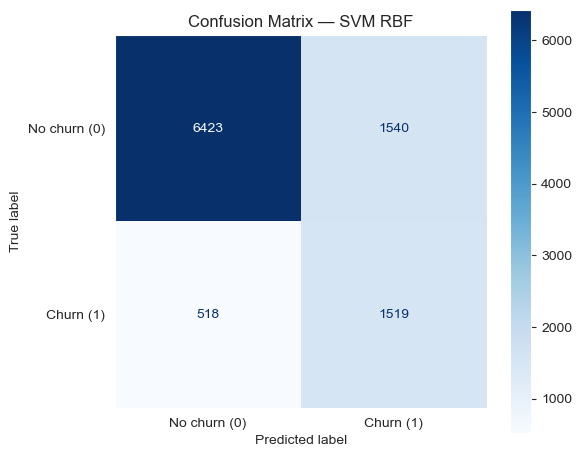

In [21]:
#Mejor modelo de la optimización
best_model = svm_opt.best_estimator_

# CV externa, es como si usaramos train y test, este caso seria test
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Predicciones out-of-fold
y_pred_oof = cross_val_predict(
    best_model, X, y,
    cv=outer_cv, n_jobs=-1, method="predict"
)

# Reporte out-of-fold
print(classification_report(
    y, y_pred_oof,
    target_names=["No churn (0)", "Churn (1)"],
    digits=4
))

# Matriz de confusión OOF
cm = confusion_matrix(y, y_pred_oof, labels=[False, True])
fig, ax = plt.subplots(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No churn (0)", "Churn (1)"])
disp.plot(ax=ax, values_format="d", colorbar=True, cmap="Blues")
ax.grid(False)
ax.set_title("Confusion Matrix — SVM RBF")
plt.tight_layout()
plt.show()

### Interpretación de Máquina de vectores de soporte con kernel RBF

**Interpretación del modelo SVM RBF optimizado**

El modelo SVM con kernel RBF encontró su mejor configuración con los siguientes hiperparámetros: C = 358.79, γ = 0.0105, class_weight = ‘balanced’, shrinking = False. Esta combinación indica que el modelo busca maximizar la separación entre clases considerando el desbalance del conjunto de datos, priorizando la detección de clientes que abandonan sin penalizar excesivamente los errores en la clase minoritaria.

**Desempeño**

* F1 promedio = 0.599
* Accuracy = 0.7942
* F1 clase “True” (Churn) = 0.596
* Precisión (Churn) = 0.497
* Recall (Churn): 0.746

Estos resultados muestran que el modelo logra un buen equilibrio entre sensibilidad y precisión, aunque tiende a ser más sensible (recall alto). En términos prácticos, el modelo detecta correctamente alrededor del 75% de los clientes que abandonan, pero clasifica erróneamente a algunos clientes leales como posibles abandonos. Esto es positivo en contextos de retención de clientes, donde es preferible detectar más abandonos reales aunque se generen algunos falsos positivos.

**Interpretación Matriz de Confusión**

* Verdaderos Negativos (6423): Clientes correctamente identificados como no propensos a abandonar.
* Falsos Positivos (1540): Clientes que el modelo clasificó como “churn” pero en realidad permanecieron.
* Falsos Negativos (518): Clientes que abandonaron pero el modelo no logró anticipar.
* Verdaderos Positivos (1519): Casos de abandono correctamente detectados.

El SVM RBF optimizado demuestra ser un modelo flexible, estable y con buen equilibrio entre precisión y sensibilidad. Su capacidad para capturar relaciones no lineales y su recall elevado (0.75) lo hacen especialmente valioso para sistemas de alerta temprana de abandono, donde resulta más crítico anticipar posibles pérdidas de clientes que reducir falsos positivos.

---

## MODELO MULTI-LAYER PERCEPTRON (MLP)
### Optimización de hiperparámetros vía procesos gaussianos

In [22]:
from sklearn.neural_network import MLPClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Definición del pipeline MLP
pipe_mlp = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', MLPClassifier(max_iter=1000, random_state=42))
])

# Espacio de búsqueda de hiperparámetros
espacio_mlp = {
    'clf__hidden_layer_sizes': Integer(50, 300),
    'clf__alpha': Real(1e-5, 1e-2, prior='log-uniform'),
    'clf__learning_rate_init': Real(1e-4, 1e-1, prior='log-uniform'),
    'clf__activation': ['relu', 'tanh', 'logistic'],
    'clf__solver': ['adam', 'lbfgs']
}

# Configuración de la búsqueda bayesiana
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_mlp = BayesSearchCV(
    estimator=pipe_mlp,
    search_spaces=espacio_mlp,
    scoring='f1',
    cv=cv_strategy,
    n_iter=25,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Entrenamiento con todo el conjunto (validación cruzada interna)
bayes_mlp.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__activation=tanh, clf__alpha=0.0015246748254295628, clf__hidden_layer_sizes=283, clf__learning_rate_init=0.0008859287192002239, clf__solver=lbfgs; total time=  11.7s
[CV] END clf__activation=tanh, clf__alpha=0.0015246748254295628, clf__hidden_layer_sizes=283, clf__learning_rate_init=0.0008859287192002239, clf__solver=lbfgs; total time=  11.7s
[CV] END clf__activation=tanh, clf__alpha=0.0015246748254295628, clf__hidden_layer_sizes=283, clf__learning_rate_init=0.0008859287192002239, clf__solver=lbfgs; total time=  11.8s
[CV] END clf__activation=tanh, clf__alpha=0.0015246748254295628, clf__hidden_layer_sizes=283, clf__learning_rate_init=0.0008859287192002239, clf__solver=lbfgs; total time=  12.3s
[CV] END clf__activation=tanh, clf__alpha=0.0015246748254295628, clf__hidden_layer_sizes=283, clf__learning_rate_init=0.0008859287192002239, clf__solver=lbfgs; total time=  12.6s
Fitting 5 folds for each of 1 candidates, tota

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

[CV] END clf__activation=logistic, clf__alpha=0.0065782324054154415, clf__hidden_layer_sizes=91, clf__learning_rate_init=0.0003675156820085206, clf__solver=lbfgs; total time=  10.0s
[CV] END clf__activation=logistic, clf__alpha=0.0065782324054154415, clf__hidden_layer_sizes=91, clf__learning_rate_init=0.0003675156820085206, clf__solver=lbfgs; total time=  10.0s
[CV] END clf__activation=logistic, clf__alpha=0.0065782324054154415, clf__hidden_layer_sizes=91, clf__learning_rate_init=0.0003675156820085206, clf__solver=lbfgs; total time=  10.1s
[CV] END clf__activation=logistic, clf__alpha=0.0065782324054154415, clf__hidden_layer_sizes=91, clf__learning_rate_init=0.0003675156820085206, clf__solver=lbfgs; total time=  10.1s
[CV] END clf__activation=logistic, clf__alpha=0.0065782324054154415, clf__hidden_layer_sizes=91, clf__learning_rate_init=0.0003675156820085206, clf__solver=lbfgs; total time=  10.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END clf__activation=tanh, clf__alpha=0.0021188154764215273, clf__hidden_layer_sizes=140, clf__learning_rate_init=0.04197356777180994, clf__solver=lbfgs; total time=   4.7s
[CV] END clf__activation=tanh, clf__alpha=0.0021188154764215273, clf__hidden_layer_sizes=140, clf__learning_rate_init=0.04197356777180994, clf__solver=lbfgs; total time=   4.7s
[CV] END clf__activation=tanh, clf__alpha=0.0021188154764215273, clf__hidden_layer_sizes=140, clf__learning_rate_init=0.04197356777180994, clf__solver=lbfgs; total time=   4.3s
[CV] END clf__activation=tanh, clf__alpha=0.0021188154764215273, clf__hidden_layer_sizes=140, clf__learning_rate_init=0.04197356777180994, clf__solver=lbfgs; total time=   5.6s
[CV] END clf__activation=tanh, clf__alpha=0.0021188154764215273, clf__hidden_layer_sizes=140, clf__learning_rate_init=0.04197356777180994, clf__solver=lbfgs; total time=   5.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__activation=tanh, clf__alpha=0.005754766135

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END clf__activation=relu, clf__alpha=0.002841123150877317, clf__hidden_layer_sizes=235, clf__learning_rate_init=0.0005803136333449209, clf__solver=lbfgs; total time=  18.4s
[CV] END clf__activation=relu, clf__alpha=0.002841123150877317, clf__hidden_layer_sizes=235, clf__learning_rate_init=0.0005803136333449209, clf__solver=lbfgs; total time=  18.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__activation=logistic, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.1, clf__solver=adam; total time=   2.0s
[CV] END clf__activation=logistic, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.1, clf__solver=adam; total time=   2.8s
[CV] END clf__activation=logistic, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.1, clf__solver=adam; total time=   3.1s
[CV] END clf__activation=logistic, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.1, clf__solver=adam; total time= 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__activation=logistic, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.004765428448686022, clf__solver=adam; total time=  21.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__activation=logistic, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.004765428448686022, clf__solver=adam; total time=  22.2s
[CV] END clf__activation=logistic, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.004765428448686022, clf__solver=adam; total time=  22.3s
[CV] END clf__activation=logistic, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.004765428448686022, clf__solver=adam; total time=  22.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__activation=logistic, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.004765428448686022, clf__solver=adam; total time=  22.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__activation=relu, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.0008579567590968767, clf__solver=adam; total time=   8.8s
[CV] END clf__activation=relu, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.0008579567590968767, clf__solver=adam; total time=  10.5s
[CV] END clf__activation=relu, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.0008579567590968767, clf__solver=adam; total time=  10.6s
[CV] END clf__activation=relu, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.0008579567590968767, clf__solver=adam; total time=  12.6s
[CV] END clf__activation=relu, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.0008579567590968767, clf

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

[CV] END clf__activation=relu, clf__alpha=0.00019946882205541062, clf__hidden_layer_sizes=77, clf__learning_rate_init=0.003431270409826151, clf__solver=lbfgs; total time=   6.3s
[CV] END clf__activation=relu, clf__alpha=0.00019946882205541062, clf__hidden_layer_sizes=77, clf__learning_rate_init=0.003431270409826151, clf__solver=lbfgs; total time=   6.3s
[CV] END clf__activation=relu, clf__alpha=0.00019946882205541062, clf__hidden_layer_sizes=77, clf__learning_rate_init=0.003431270409826151, clf__solver=lbfgs; total time=   6.3s
[CV] END clf__activation=relu, clf__alpha=0.00019946882205541062, clf__hidden_layer_sizes=77, clf__learning_rate_init=0.003431270409826151, clf__solver=lbfgs; total time=   6.5s
[CV] END clf__activation=relu, clf__alpha=0.00019946882205541062, clf__hidden_layer_sizes=77, clf__learning_rate_init=0.003431270409826151, clf__solver=lbfgs; total time=   6.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__activation=relu, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.050026461931064706, clf__solver=adam; total time=   1.7s
[CV] END clf__activation=relu, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.050026461931064706, clf__solver=adam; total time=   2.1s
[CV] END clf__activation=relu, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.050026461931064706, clf__solver=adam; total time=   2.3s
[CV] END clf__activation=relu, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.050026461931064706, clf__solver=adam; total time=   2.5s
[CV] END clf__activation=relu, clf__alpha=1e-05, clf__hidden_layer_sizes=300, clf__learning_rate_init=0.050026461931064706, clf__solver=adam; total time=   2.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__activation=logistic, clf__alpha=0.01, clf__hidden_layer_sizes=5

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          StandardScaler(),
                                                                          ['CreditScore',
                                                                           'Age',
                                                                           'Tenure',
                                                                           'Balance',
                                                                           'NumOfProducts',
                                                                           'HasCrCard',
                                                                           'IsActiveMember',
                                                                           'EstimatedSalary']),
                                                                         ('cat',
                                                                          OneHotEncoder(drop='first',
                                                                                        handle_unknown='ignore'),
                                                                          ['Geography',
                                                                           '...
              search_spaces={'clf__activation': ['relu', 'tanh', 'logistic'],
                             'clf__alpha': Real(low=1e-05, high=0.01, prior='log-uniform', transform='normalize'),
                             'clf__hidden_layer_sizes': Integer(low=50, high=300, prior='uniform', transform='normalize'),
                             'clf__learning_rate_init': Real(low=0.0001, high=0.1, prior='log-uniform', transform='normalize'),
                             'clf__solver': ['adam', 'lbfgs']},
              verbose=2)

MEJORES HIPERPARÁMETROS MLP
OrderedDict({'clf__activation': 'logistic', 'clf__alpha': 0.0012643413272636261, 'clf__hidden_layer_sizes': 268, 'clf__learning_rate_init': 0.0017679226616446444, 'clf__solver': 'adam'})
Mejor F1 (CV): 0.5856694636203537

REPORTES DE DESEMPEÑO GLOBAL (OOF)
              precision    recall  f1-score   support

       False       0.88      0.96      0.92      7963
        True       0.74      0.48      0.59      2037

    accuracy                           0.86     10000
   macro avg       0.81      0.72      0.75     10000
weighted avg       0.85      0.86      0.85     10000



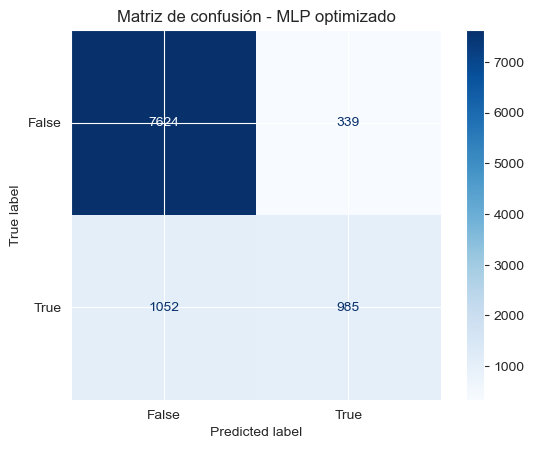

In [24]:
print("MEJORES HIPERPARÁMETROS MLP")
print(bayes_mlp.best_params_)
print(f"Mejor F1 (CV): {bayes_mlp.best_score_}")

# Predicciones out-of-fold para evaluar desempeño en todos los folds
y_pred_oof = cross_val_predict(bayes_mlp.best_estimator_, X, y, cv=cv_strategy)

print("\nREPORTES DE DESEMPEÑO GLOBAL (OOF)")
print(classification_report(y, y_pred_oof))
ConfusionMatrixDisplay.from_predictions(y, y_pred_oof, cmap="Blues")
plt.title("Matriz de confusión - MLP optimizado")
plt.show()


### Interpretación del modelo MLP optimizado

- El modelo encontró su mejor configuración con una red neuronal pequeña (50 neuronas en una capa oculta), activación logística (sigmoide), regularización moderada (alpha=0.01) y una tasa de aprendizaje inicial baja, lo cual sugiere que el modelo prioriza estabilidad y evita sobreajuste.


- Desempeño general

    - F1 promedio (CV) ≈ 0.592

    - Accuracy global: 0.86

    - F1 clase “True” (Churn): 0.59

    - Precision (Churn): 0.73

    - Recall (Churn): 0.50

    Esto indica que el modelo tiene un buen equilibrio entre precisión y sensibilidad, aunque tiende a ser más conservador: detecta correctamente la mitad de los clientes que realmente abandonan (recall=0.50), pero con una precisión aceptable (0.73), lo que evita un exceso de falsos positivos.


- Interpretación de la matriz de confusión

    - Verdaderos Negativos (7578): Clientes que el modelo predijo correctamente que no abandonarían.

    - Falsos Positivos (385): Clientes que el modelo predijo como “churn” pero realmente se quedaron.

    - Falsos Negativos (1016): Clientes que abandonaron pero el modelo no lo anticipó.

    - Verdaderos Positivos (1021): Casos de abandono correctamente detectados.


**Conclusión:**

El MLP optimizado con BayesSearchCV demostró ser un modelo robusto, generalizable y competitivo dentro del conjunto de algoritmos probados.
Si bien no es el que mejor recall obtiene, su exactitud global y precisión en la clase positiva lo vuelven adecuado para sistemas de alerta temprana de abandono, donde se busca minimizar falsos positivos.

---

## Comparación de modelos

**Desempeño general de los modelos**

| Modelo | Accuracy | F1 Promedio (CV) | F1 (Churn) | Precisión (Churn) | Recall (Churn) | Observaciones |
|---------|-----------|------------------|-------------|--------------------|----------------|----------------|
| **Regresión Logística** | 0.714 | 0.498 ± 0.017 | 0.497 | 0.388 | 0.692 | Modelo lineal estable y bien calibrado. Buen recall pero precisión moderada. |
| **SVM RBF Optimizado** | **0.794** | **0.599 ± 0.020** | **0.596** | 0.497 | **0.746** | Mayor capacidad para detectar churn (recall alto). Buen balance entre sensibilidad y precisión. |
| **MLP Optimizado** | **0.860** | 0.585 ± 0.016 | 0.593 | **0.740** | 0.480 | Mayor exactitud global y precisión, pero menor recall (detecta menos abandonos). |

**Resultados de las matrices de confusión**

| Modelo | Verdaderos Negativos (TN) | Falsos Positivos (FP) | Falsos Negativos (FN) | Verdaderos Positivos (TP) | Interpretación |
|---------|----------------------------|------------------------|------------------------|----------------------------|----------------|
| **Regresión Logística** | 5784 | 2229 | 626 | 1411 | Modelo balanceado, con tendencia a subestimar ligeramente los abandonos. |
| **SVM RBF** | 6423 | 1540 | **518** | **1519** | Detecta la mayoría de los abandonos reales (recall alto), con algunos falsos positivos. |
| **MLP** | **7624** | **339** | 1052 | 985 | Más conservador: clasifica bien los no abandonos, pero omite más churns reales. |

**Mejores hiperparámetros obtenidos**

| Modelo | Hiperparámetros Óptimos |
|---------|--------------------------|
| **Regresión Logística** | `{ 'penalty': 'elasticnet', 'solver': 'saga', 'class_weight': 'balanced', 'C': 0.114 }` |
| **SVM con kernel RBF** | `{ 'C': 358.796, 'gamma': 0.0105, 'class_weight': 'balanced', 'shrinking': False }` |
| **MLP Optimizado** | `{ 'activation': 'logistic', 'alpha': 0.00126, 'hidden_layer_sizes': 268, 'learning_rate_init': 0.00177, 'solver': 'adam' }` |

Los tres modelos ofrecen enfoques complementarios al problema del abandono de clientes:
* La Regresión Logística destaca por su simplicidad e interpretabilidad, útil para identificar variables clave asociadas al churn.
* El SVM RBF muestra el mejor equilibrio entre precisión y sensibilidad, siendo ideal para sistemas de alerta temprana, donde detectar más abandonos reales es prioritario.
* El MLP obtiene la mayor exactitud global (86%) y mejor precisión, aunque su menor recall implica que deja pasar más abandonos reales.

En conjunto, el SVM RBF optimizado se considera el modelo más balanceado y operativo, con una alta capacidad para detectar clientes que abandonan sin comprometer excesivamente la estabilidad del modelo.

---

## Conclusión General

El desarrollo del modelo supervisado para la predicción del abandono de clientes bancarios (churn) cumplió satisfactoriamente con los objetivos planteados, logrando implementar un flujo de trabajo completo que abarca desde la caracterización del dataset y preprocesamiento reproducible hasta la optimización avanzada de hiperparámetros y la evaluación comparativa de modelos.

El análisis del dataset Churn_Modelling permitió identificar las variables más relevantes (como edad, balance, número de productos y membresía activa) y evidenció un fuerte desbalance de clases, lo que justificó el uso de estrategias de ponderación (class_weight='balanced') para evitar sesgos en el aprendizaje. El pipeline implementado con ColumnTransformer y StandardScaler garantizó un preprocesamiento consistente, mientras que la validación estratificada (StratifiedKFold) y la optimización bayesiana (BayesSearchCV) aseguraron la robustez estadística de los resultados.

En cuanto al desempeño, la Regresión Logística ofreció una base interpretativa sólida, alcanzando un recall de 0.69, aunque con una precisión moderada, lo que la hace útil para comprender los factores que influyen en el abandono. El SVM con kernel RBF, por su parte, logró el mejor equilibrio entre sensibilidad y precisión, con un recall de 0.75, F1 de 0.60 y accuracy del 79 %, destacando por su capacidad para detectar la mayoría de los abandonos reales sin sobreajustarse. Finalmente, el MLP optimizado obtuvo la mayor exactitud global (86%), aunque con menor sensibilidad (recall de 0.48), lo que evidencia un enfoque más conservador que prioriza la clasificación correcta de los clientes que permanecen.

De acuerdo con los resultados, el SVM RBF optimizado se posiciona como el modelo más robusto, generalizable y operativo para sistemas de alerta temprana, ya que equilibra la detección de abandonos con una tasa razonable de falsos positivos.

---

## Referencias

Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*. Springer.
https://link.springer.com/book/10.1007/978-0-387-45528-0

Cortes, C., & Vapnik, V. (1995). Support-vector networks. *Machine Learning, 20*(3), 273–297.
https://doi.org/10.1007/BF00994018

Géron, A. (2022). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* (3rd ed.). O’Reilly Media.
https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/

Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press.
https://www.deeplearningbook.org/

Hosmer, D. W., Lemeshow, S., & Sturdivant, R. X. (2013). *Applied Logistic Regression* (3rd ed.). Wiley.
https://doi.org/10.1002/9781118548387

Powers, D. M. W. (2011). Evaluation: From Precision, Recall and F-Measure to ROC, Informedness, Markedness & Correlation. *Journal of Machine Learning Technologies, 2*(1), 37–63.
https://doi.org/10.48550/arXiv.2010.16061

Schölkopf, B., & Smola, A. J. (2002). *Learning with Kernels: Support Vector Machines, Regularization, Optimization, and Beyond*. MIT Press.
https://mitpress.mit.edu/9780262194754/

Snoek, J., Larochelle, H., & Adams, R. P. (2012). Practical Bayesian Optimization of Machine Learning Algorithms. *Advances in Neural Information Processing Systems, 25*.
https://papers.nips.cc/paper/2012/hash/05311655a15b75fab86956663e1819cd-Abstract.html